## Sentiment Classification Using Proposed CNN-GNN on MR Polarity dataset + Token Sentiment Injection + Dataset Partitioning

In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from nltk.tokenize import TweetTokenizer
import time
from torch_scatter import scatter_max, scatter_mean, scatter_std
from sklearn.model_selection import KFold
import torchmetrics
import lightning as L
from torch_geometric.data import Batch, Data
from tqdm import tqdm
import spacy
import string
import os
import re
import math
import pickle 
from torch import nn
from torch.utils.flop_counter import FlopCounterMode
from transformers import AutoModel, DebertaV2Tokenizer, AutoTokenizer
import matplotlib.pyplot as plt
from torch_geometric.nn import GATv2Conv, summary
from tqdm import tqdm
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, hinge_loss
from torchmetrics import ConfusionMatrix
from codes.scripts.utilities import ClassifierModelManager, CnnGnnClassifierLightningModel
from os import path

In [2]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-large")
id_vocab = {v:k for k,v in tokenizer.vocab.items()}

f:\Articles\CGNet\venv\Lib\site-packages\transformers\convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [3]:
with open(r'Data\ReducedEmbeddings\deberta_larg_reduced_embeddings_64.npy', 'rb') as f:
    embeddings = np.load(f)
embeddings = torch.from_numpy(embeddings)
all_vocab_str = []
for i in range(len(id_vocab)):
    all_vocab_str.append(id_vocab[i])
    
# embeddings = (embeddings - torch.min(embeddings)) / (torch.max(embeddings)-torch.min(embeddings))
token_vocab_dict = dict(zip(all_vocab_str, embeddings))
# del all_vocab_str
# del all_vocab_doc

In [4]:
with open(r'Data\ReducedEmbeddings\polarity_debertav3_tokens_gpt_mini_emb.npy', 'rb') as f:
    polarities_subjectivities= np.load(f)
polarities_subjectivities = torch.from_numpy(polarities_subjectivities)
polarity_vocab_dict = dict(zip(all_vocab_str, polarities_subjectivities))
polarity_vocab_dict['<n>'] = torch.tensor([0.0, 0.0])
len(token_vocab_dict)

128001

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 100
num_embedding=12288
device

device(type='cuda')

In [6]:
def load_dataset(dataset_path, shuffle = False):
    pos_path = os.path.join(dataset_path, 'pos')
    neg_path = os.path.join(dataset_path, 'neg')
    pos_names = os.listdir(pos_path)
    neg_names = os.listdir(neg_path)
    df = []
    for pname in pos_names:
        file_path = os.path.join(pos_path, pname)
        with open(file_path, 'rt', encoding='utf8') as f:
            df.append([1, f.read()])
    
    for nname in neg_names:
        file_path = os.path.join(neg_path, nname)
        with open(file_path, 'rt', encoding='utf8') as f:
            df.append([0, f.read()])
    df = pd.DataFrame(data=df, columns=['label', 'text'])
    if shuffle:
        df = df.sample(frac=1).reset_index(drop=True)
    return df

keep_ratio = 1.0
df = load_dataset(r'Data\TextClassification\review_polarity')
# df.text = df.text.apply(lambda d: d[:50])
df.dropna(inplace=True)
df = df.iloc[:int(keep_ratio*df.shape[0])]
target_classes = ["Negative", "Positive"]
df.shape

(2000, 2)

In [7]:
class_list = df.label.unique()
class_id = {target_classes[i]:i for i in class_list}
id_class = {i:target_classes[i] for i in class_list}

In [8]:
with open(r'Data\ReducedEmbeddings\term_frequencies.pkl', 'rb') as f:
    term_frequencies = pickle.load(f)

In [9]:
threshold = 0.00001
total_token_count = np.array(list(term_frequencies.values())).sum()
one_tensor = torch.tensor(1)
def subsampling_equation_linear(x: torch.Tensor):
    f_x = x/total_token_count
    x = torch.min(one_tensor, torch.sqrt_(threshold/f_x))
    return x

def subsampling_equation_sigmoid(x: torch.Tensor):
    f_x = x/total_token_count
    x = 1-0.95*F.sigmoid(0.05*((f_x/threshold)-90))
    return x


In [10]:
class KFoldCharacterandTokenLevelDataset(Dataset):
    
    def __init__(self, X, y, num_classes, token_dict, sentiment_dict, tokenizer, token_frequencies, sampling_equation, shuffle=True, batch_size=128, k_folds=10, fold_idx=0) -> None:
        super().__init__()
        self.fold_idx = fold_idx
        kf = KFold(k_folds, shuffle=True, random_state=42)
        self.k_folds = list(kf.split(np.arange(len(y))))
        self.k_folds = [(np.array(f[0], dtype=np.longlong), np.array(f[1], dtype=np.longlong)) for f in self.k_folds]
        print(f'len(y): {len(y)}')
        print(f'k_folds: {k_folds}')
        if batch_size > len(y)//k_folds:
            batch_size = len(y)//k_folds
        self.batch_size = batch_size
        
        print(f'batch_size: {batch_size}')
        if len(y) % batch_size*k_folds != 0:
            
            self.shortage = ((len(y) // (batch_size*k_folds))+1)*(batch_size*k_folds) - len(y)
            print(f"!!!! This amount of data added: {self.shortage}, change batch size or k-fold to reduce it!")
            empty_labels = [i%2 for i in range(self.shortage)]
            empty_strings = [id_class[l] for l in empty_labels]
            y = np.concatenate([y, empty_labels])
            X = np.concatenate([X, empty_strings])
        
        y = torch.from_numpy(y)
        self.shuffle = shuffle
        self.y = torch.nn.functional.one_hot(y, num_classes=num_classes).float()
        self.X = X
        self.tokenizer = tokenizer
        self.token_dict = token_dict
        self.sentiment_dict = sentiment_dict
        self.token_frequencies = token_frequencies
        self.max_token_count = 0
        
        self.all_data = []
        self.token_lengths = []
        self.token_embeddign_ids = []
        
        self.sum_a = 0
        
        for doc in tqdm(self.X):
            g_data = self.content_to_graph(doc, sampling_equation)
            self.all_data.append(g_data)
            
        self.all_data = Batch.from_data_list(self.all_data)
        self.update_split(self.fold_idx)
        
    def update_split(self, fold_idx):
        self.active_fold = self.k_folds[fold_idx]
        
        self.train_y = self.y[self.active_fold[0]]
        self.test_y = self.y[self.active_fold[1]]
        
        self.all_train_data = self.all_data[self.active_fold[0]]
        self.all_test_data = self.all_data[self.active_fold[1]]
        self.train()
        
    def train(self):
        self.update_sections(self.train_y, self.all_train_data)
        self.is_train=True
        
    def eval(self):
        self.update_sections(self.test_y, self.all_test_data)
        self.is_train=False
        
    def update_sections(self, y, all_data):
        
        self.num_sections = len(y) // batch_size
        self.x_lengths = np.array([all_data[i].character_length[0] for i in range(len(all_data))])
        self.x_len_args = np.argsort(self.x_lengths)[::-1]
        
        self.section_ranges = np.linspace(0, len(self.x_len_args), self.num_sections+1)
        self.section_ranges = [(int(self.section_ranges[i-1]), int(self.section_ranges[i])) for i in range(1, len(self.section_ranges))]

        self.position_j = 0
        self.section_i = 0
        self.epoch = 0
        self.each_section_i = np.zeros((self.num_sections, ), dtype=int)
        
        self.sections, self.section_size = self.split_into_k_groups(self.x_len_args, self.x_lengths, self.num_sections)
        return self.sections, self.section_size, self.x_len_args, self.x_lengths, self.num_sections
        
    def __getitem__(self, index):
        index = self.get_section_index(index+1)
        if self.is_train:
            return self.all_train_data[index], self.train_y[index]
        else:
            return self.all_test_data[index], self.test_y[index]
    
    def __len__(self):
        return len(self.y)
    
    def get_section_index(self, index):
        position_j = index % self.section_size
        section_i = (index //self.section_size) % self.num_sections
        target_index = self.sections[section_i, position_j]
        
        # self.position_j = (self.position_j + 1) % self.section_size
        # if self.position_j == 0:
        #     self.section_i = (self.section_i + 1) % self.num_sections
        #     if self.shuffle and self.section_i == 0:
        #         self.sections, self.section_size = self.split_into_k_groups(self.x_len_args, self.x_lengths, self.num_sections)
        return target_index 
    
    def reset_params(self):
        self.section_i = 0
        self.position_j = 0
        self.each_section_i = np.zeros((self.num_sections, ), dtype=int)
        
    def split_into_k_groups(self, len_sorted_args, lengths:np.array, k):
        if self.shuffle and self.epoch > 0:
            randomize_sections = np.concatenate([np.random.choice(np.arange(r[0], r[1]), size=r[1]-r[0], replace=False) for r in self.section_ranges])
            len_sorted_args = len_sorted_args[randomize_sections]
        
        nums = lengths[len_sorted_args]
        groups_size = len(len_sorted_args) // k
        
        groups = [[] for _ in range(k)]
        group_sums = np.zeros(k, dtype=int)
        group_sizes = np.zeros(k, dtype=int)
        
        for i, num in enumerate(nums):
            candidate_indices = np.where(group_sizes<groups_size)[0]
            min_group_idx = candidate_indices[np.argmin(group_sums[candidate_indices])]
            groups[min_group_idx].append(len_sorted_args[i])
            group_sums[min_group_idx] += num
            group_sizes[min_group_idx] += 1
        self.epoch += 1
        
        groups = np.array(groups)
        group_sums_argsort = np.argsort(group_sums)[::-1]
        groups = groups[group_sums_argsort]
                
        return np.array(groups), groups_size
    
    def content_to_graph(self, doc, sampling_equation):
        tokens = self.tokenizer(doc)
        if len(tokens) == 0:
            tokens = ['empty']
                        
        token_lengths = [len(t) for t in tokens]
        tokens.append('')
        
        token_lengths.append(len(tokens[-1])-1)
        token_lengths = torch.from_numpy(np.array(token_lengths, dtype=np.longlong))+1
        token_embs = [self.token_dict[t] if t in self.token_dict else torch.zeros((64, ), dtype=torch.float32) for t in tokens]
        token_sentiments = [self.sentiment_dict[t] if t in self.sentiment_dict else (0.0, 0.0) for t in tokens]
        token_embs = torch.from_numpy(np.array(token_embs, dtype=np.float32))
        token_sentiments = torch.from_numpy(np.array(token_sentiments, dtype=np.float32))
        doc = ' '.join(tokens)
        characters = torch.from_numpy(np.array([ord(t) if ord(t)<num_embedding else (num_embedding-1) for t in doc], dtype=np.longlong))
        token_positions = torch.arange(len(token_lengths), dtype=torch.long)
        token_indices = torch.repeat_interleave(token_positions, token_lengths)
        token_subsampling_probabilities = sampling_equation(torch.from_numpy(np.array([self.token_frequencies[t] if t in self.token_frequencies else 1 for t in tokens])))
        num_tokens = len(token_lengths)
        if num_tokens > self.max_token_count:
            self.max_token_count = num_tokens
        g_data = Data(x=characters,
                        token_positions=token_positions,
                        character_length = len(characters),
                        num_tokens = num_tokens,
                        token_indices=token_indices,
                        token_lengths=token_lengths,
                        token_embeddings=token_embs,
                        token_sentiments=token_sentiments,
                        token_subsampling_probabilities=token_subsampling_probabilities)
        return g_data
        

In [11]:
class TrainTestDatasetWrapper(Dataset):
    
    def __init__(self, target_dataset, is_train=True) -> None:
        super().__init__()
        self.dataset = target_dataset
        self.is_train = is_train
    
    def __getitem__(self, index):
        if self.is_train:
            if not self.dataset.is_train:
                self.dataset.train()
            return self.dataset[index]
        else:
            if self.dataset.is_train:
                self.dataset.eval()
            return self.dataset[index]
    
    def set_active_fold(self, fold_idx):
        self.dataset.update_split(fold_idx)
    
    def reset_params(self):
        self.dataset.reset_params()
        
    def __len__(self):
        if self.is_train:
            return len(self.dataset.train_y)
        else:
            return len(self.dataset.test_y)

In [12]:
from typing import List
from torch_geometric.loader import DataLoader

class CharacterandTokenLevelDataLoader(DataLoader):
    def __init__(
        self,
        dataset,
        batch_size: int = 1,
        shuffle: bool = False,
        follow_batch: List[str] | None = None,
        exclude_keys: List[str] | None = None,
        **kwargs,
    ):
        super(CharacterandTokenLevelDataLoader, self).__init__(
            dataset, batch_size, shuffle, follow_batch, exclude_keys, **kwargs
        )

    def __iter__(self):
        base_iterator = super(CharacterandTokenLevelDataLoader, self).__iter__()
        for batch in base_iterator:
            cumsum_vals = torch.cumsum(batch[0].num_tokens, dim=0).roll(1)
            cumsum_vals[0] = 0
            additions = torch.repeat_interleave(cumsum_vals, batch[0].character_length)
            batch[0].cumulative_token_indices = batch[0].token_indices + additions
            yield batch


In [13]:
main_dataset = KFoldCharacterandTokenLevelDataset(df.text.values, df.label.values, len(class_id), token_vocab_dict, polarity_vocab_dict, tokenizer.tokenize, token_frequencies=term_frequencies, sampling_equation=subsampling_equation_sigmoid, batch_size=batch_size, shuffle=False)
batch_size = main_dataset.batch_size

len(y): 2000
k_folds: 10
batch_size: 100


100%|██████████| 2000/2000 [01:49<00:00, 18.29it/s]


In [15]:
main_dataset

In [16]:
train_dataset = TrainTestDatasetWrapper(main_dataset, True)
test_dataset = TrainTestDatasetWrapper(main_dataset, False)
train_dataset.set_active_fold(0)
test_dataset.set_active_fold(0)
train_dataloader = CharacterandTokenLevelDataLoader(train_dataset, batch_size=batch_size, drop_last=False, shuffle=False)
test_dataloader = CharacterandTokenLevelDataLoader(test_dataset, batch_size=batch_size, drop_last=False, shuffle=False)

In [17]:
X, y = next(iter(test_dataloader))

In [21]:
y.sum(dim=0)

tensor([51., 49.])

## Model Classes and Functions

In [34]:
class GCNN(nn.Module):
    def __init__(self, hidden_dim, edge_dim=None, *args, **kwargs):
        super(GCNN, self).__init__(*args, **kwargs)
        self.gnn = GATv2Conv(hidden_dim, hidden_dim//8, heads=4, edge_dim=edge_dim, add_self_loops=False)
        self.conv = nn.Conv1d(hidden_dim, hidden_dim//2, kernel_size=3, padding=1)
        self.fc = nn.Linear(hidden_dim//2, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim//2)
        
    def forward(self, x, edge_data, edge_attr=None, return_attention_weights = False):
        x1, edge_weights = self.gnn(x, edge_data, edge_attr=edge_attr, return_attention_weights=return_attention_weights) 
        x2 = F.relu(self.conv(x.T).T)
        x1 = F.leaky_relu_(self.bn1(x1))
        x = torch.cat([x1, x2], dim=1)
        return x, edge_weights, edge_data

In [35]:
from utilities.model_layers.SentimentInjection import SentimentInjection

In [36]:
class GenGraph(nn.Module):
    
    def __init__(self, hidden_dim, virtual_nodes, lattice_step, lattice_pattern=None, head=4, *args, **kwargs):
        super(GenGraph, self).__init__(*args, **kwargs)
        self.hidden_dim = hidden_dim
        self.head = head
        self.virtual_nodes = virtual_nodes
        self.lattice_step = lattice_step
        # lp: lattice pattern
        self.lp = lattice_pattern if lattice_pattern is None else torch.tensor(lattice_pattern)
        self.virtual_node_embeddings = nn.Embedding(self.virtual_nodes, hidden_dim)
        
    def gen_graph(self, x, token_subsampling_probabilities, total_token_counts, token_counts, random_edges, lattice_edges, lattice_start_distance=2):
        random_links, lattice_links, token_batch_idx = self.calculate_graph(x, total_token_counts, token_counts, random_edges, lattice_edges, lattice_start_distance)
        v_n_e_counts = total_token_counts*self.virtual_nodes
        base_numel = random_links.numel() + lattice_links.numel()*2
        edge_indices = torch.empty((2, base_numel + v_n_e_counts*2), dtype=torch.int64, device=x.device)
        self.fill_lattice_and_random_edges(edge_indices, random_links, lattice_links, token_batch_idx)
            
        if self.virtual_nodes > 0:
            virtual_nodes_range = torch.arange(self.virtual_nodes, device=x.device).view(1, -1)
            virtual_nodes_ids = torch.repeat_interleave(virtual_nodes_range, len(token_counts), dim=0)
            v_n_idx = (virtual_nodes_ids + torch.arange(0, len(token_counts)*self.virtual_nodes, self.virtual_nodes, device=x.device).view(-1, 1) + total_token_counts )
            virtual_edge_ids = torch.repeat_interleave(v_n_idx.view(-1), token_counts.view(-1, 1).expand(len(token_counts), self.virtual_nodes).reshape(-1), dim=0).view(1, -1)
            
            embs = self.virtual_node_embeddings(virtual_nodes_ids.T).view(-1, self.hidden_dim)
            x_extended = torch.cat([x, embs], dim=0)
            x_index = torch.arange(total_token_counts, device=x.device).repeat(self.virtual_nodes).view(1, -1)
            edge_indices[:, base_numel:base_numel+v_n_e_counts] = torch.cat([x_index, virtual_edge_ids], dim=0)
            edge_indices[:, base_numel+v_n_e_counts:] = torch.cat([virtual_edge_ids, x_index], dim=0)
            x = x_extended
        
        edge_indices = self.subsample_edges(edge_indices, token_subsampling_probabilities)
        return Batch.from_data_list([Data(x=x, edge_index=edge_indices)])
        
    def re_gen_graph(self, x, edge_indices, token_subsampling_probabilities, total_token_coutns, token_counts, random_edges, lattice_edges, lattice_start_distance=2):
        random_links, lattice_links, token_batch_idx = self.calculate_graph(x, total_token_coutns, token_counts, random_edges, lattice_edges, lattice_start_distance)
        base_numel = random_links.numel() + lattice_links.numel()*2
        
        self.fill_lattice_and_random_edges(edge_indices, random_links, lattice_links, token_batch_idx)
        # for i in range(base.shape[1]):
        #     edge_indices[:, i*base.shape[0]:(i+1)*base.shape[0]] = torch.cat([token_batch_idx, base[:,i].view(1,-1)], dim=0)
        edge_indices = self.subsample_edges(edge_indices, token_subsampling_probabilities)
        return Batch.from_data_list([Data(x=x, edge_index=edge_indices)])
    
    def replace_unimportant_edges(self, edge_weights, x, edge_indices, token_subsampling_probabilities, total_token_counts, token_counts, random_edges, lattice_edges, p_keep=1, lattice_start_distance=2):
        v_n_e_counts = total_token_counts*self.virtual_nodes
        # if v_n_e_counts>0:
        #     important_indices = torch.topk(edge_weights[:-2*v_n_e_counts].view(-1, total_token_coutns), p_keep, dim=0).indices
        # else:
        #     print(f'edge_weights.shape: {edge_weights.shape}')
        #     print(f'total_token_coutns: {total_token_coutns}')
        #     print(f'p_keep: {p_keep}')
        #     important_indices = torch.topk(edge_weights.view(-1, total_token_coutns), p_keep, dim=0).indices
        # important_indices = torch.topk(edge_weights[:-1*total_token_coutns].view(-1, total_token_coutns), 1, dim=0).indices.squeeze()
        # print(f'edge_weights.shape: {edge_weights.shape}')
        # print(f'edge_indices.shape: {edge_indices.shape}')
        # print(f'1: edge_weights: {edge_weights.shape}')
        important_indices = torch.topk(edge_weights.squeeze(), p_keep*total_token_counts, dim=0).indices
        # print(f'2: important_indices: {important_indices.shape}')
        # print(f'2.5: \n {edge_weights} \n\n {important_indices}')

        # important_indices = torch.arange(total_token_counts, dtype=torch.int64, device=x.device)
        # important_indices = important_indices.view(-1)
        random_links, lattice_links, token_batch_idx = self.calculate_graph(x, total_token_counts, token_counts, random_edges, lattice_edges, lattice_start_distance)
        # print(f'3: random_links: {random_links.shape}, lattice_links: {lattice_links.shape}, token_batch_idx: {token_batch_idx.shape},')
        base_numel = random_links.numel() + lattice_links.numel()*2
        # print(f'4: base_numel: {base_numel}')
        
        new_edge_index = torch.empty((2, base_numel + important_indices.shape[0] + 2*v_n_e_counts), dtype=torch.int64, device=x.device)
        # print(f'5: new_edge_index: {new_edge_index.shape}')
        # print(f'new_edge_index.shape 1: {new_edge_index.shape}, base_numel + important_indices.shape[0] + 2*v_n_e_counts: {base_numel + important_indices.shape[0] + 2*v_n_e_counts}')
        self.fill_lattice_and_random_edges(new_edge_index, random_links, lattice_links, token_batch_idx)
        # print(f'6: new_edge_index: {new_edge_index.shape}, random_links: {random_links.shape}, lattice_links: {lattice_links.shape}, token_batch_idx: {token_batch_idx.shape}')
        # print(f'new_edge_index.shape 2: {new_edge_index.shape}, edge_indices: {edge_indices.shape}, important_indices shape: {important_indices.shape}, important_indices max: {important_indices.max()}')
        new_edge_index[:, base_numel:base_numel+important_indices.shape[0]] = edge_indices[:, important_indices]
        # print(f'7: new_edge_index: {new_edge_index.shape}')

        if(self.virtual_nodes>0):
            new_edge_index[:, -2*v_n_e_counts:] = edge_indices[:, -2*v_n_e_counts:]
            
        # for i in range(base.shape[1]):
        #     new_edge_index[:, i*base.shape[0]:(i+1)*base.shape[0]] = torch.cat([token_batch_idx, base[:,i].view(1,-1)], dim=0)
        # print(f'7.5: \n {new_edge_index} \n\n {token_subsampling_probabilities}')
        new_edge_index = self.subsample_edges(new_edge_index, token_subsampling_probabilities)
        
        return Batch.from_data_list([Data(x=x, edge_index=new_edge_index)])
    
        
    def calculate_graph(self, x, total_token_counts, token_counts, random_edges, lattice_edges, lattice_start_distance):

        tc_extended = torch.repeat_interleave(token_counts, token_counts, dim=0).view(-1,1)
        tc_lower_bound = torch.empty((len(token_counts)+1), dtype=torch.long, device=x.device) #torch.cuda.IntTensor(len(token_counts)+1) #
        tc_lower_bound[0] = 0
        tc_lower_bound[1:] = torch.cumsum(token_counts, dim=0)
        tc_lower_bound_extended = torch.repeat_interleave(tc_lower_bound[:-1], token_counts, dim=0).view(-1,1)
        # token_batch_idx range from zero to character counts in the x !
        token_batch_idx = torch.arange(tc_lower_bound[-1], device=x.device).view(-1,1)
        # torch.arange(tc_lower_bound[-1], dtype=torch.int32, device=x.device).view(-1,1)
        
        random_ints = torch.randint(0, 2*total_token_counts, (total_token_counts, random_edges), device=x.device) # torch.cuda.IntTensor(len(token_lengths), random_edges).random_()
        lattice = self.lp.to(x.device) if self.lp is not None else torch.arange(lattice_start_distance, max(lattice_start_distance, self.lattice_step*lattice_edges+1), self.lattice_step, device=x.device).view(1, -1)
        

        # exponentials = torch.pow(2, torch.arange(1, self.exp_edges+1, device=x.device)).view(1, -1)
        tc_local_range = token_batch_idx - tc_lower_bound_extended
        random_links = (((random_ints % (tc_extended - 1))+1 + tc_local_range) % tc_extended)+tc_lower_bound_extended
        lattice_links = ((lattice + tc_local_range) % tc_extended)+tc_lower_bound_extended
        
        # base = torch.cat([base1, base2], dim=1)
        token_batch_idx = token_batch_idx.view(1,-1)
        return random_links, lattice_links, token_batch_idx
    
    def fill_lattice_and_random_edges(self, edge_indices, random_links, lattice_links, token_batch_idx):
        for i in range(0, lattice_links.shape[1]*2, 2):
            edge_indices[:, i*lattice_links.shape[0]:(i+1)*lattice_links.shape[0]] = torch.cat([lattice_links[:,i//2].view(1,-1), token_batch_idx], dim=0)
            edge_indices[:, (i+1)*lattice_links.shape[0]:(i+2)*lattice_links.shape[0]] = edge_indices[:, i*lattice_links.shape[0]:(i+1)*lattice_links.shape[0]][[1, 0]]
            
        for i in range(random_links.shape[1]):
            j = i + lattice_links.shape[1]*2
            edge_indices[:, j*random_links.shape[0]:(j+1)*random_links.shape[0]] = torch.cat([random_links[:,i].view(1,-1), token_batch_idx], dim=0)
            
    def subsample_edges(self, edge_indices, token_subsampling_probabilities, keep_ratio=0.5):
        top_k_indices = torch.topk(torch.sum(token_subsampling_probabilities[edge_indices], dim=0), int(keep_ratio*edge_indices.shape[1]/self.head), dim=0).indices
        edge_indices = edge_indices[:, top_k_indices].reshape(2, -1)
        return edge_indices

In [37]:
class CGNetEmbedding(nn.Module):
    def __init__(self, embedding_dim=64, hidden_dim=64, dropout=0.2, seed=-1, random_edges=4, lattice_edges=10, lattice_step=2, lattice_start_distance=2, inject_embedding_dim=64, step_of_test = 0, head=4, *args, **kwargs):
        super(CGNetEmbedding, self).__init__(*args, **kwargs)
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.base_random_edges = random_edges
        self.base_lattice_edges = lattice_edges
        self.lattice_start_distance = lattice_start_distance
        self.step_of_test = step_of_test
        if seed>-1:
            torch.manual_seed(seed)
        self.embedding = nn.Embedding(16384, embedding_dim)
        self.dropout = nn.Dropout(p=dropout)
        self.conv1 = nn.Conv1d(embedding_dim, hidden_dim, kernel_size=5, padding=2)
        self.pool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=5, padding=2)
        self.conv3 = nn.Conv1d(2*hidden_dim + 2, hidden_dim, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=3, padding=1)
        self.sentiment1  = SentimentInjection(hidden_dim, hidden_dim)
        self.sentiment2  = SentimentInjection(hidden_dim, hidden_dim)
        self.p_layer_1 = nn.Linear(hidden_dim, head)
        self.gcnn1 = GCNN(hidden_dim)
        self.p_layer_2 = nn.Linear(hidden_dim, head)
        self.gcnn2 = GCNN(hidden_dim+inject_embedding_dim)
        self.graph_generator = GenGraph(hidden_dim, 0, lattice_step, head=head)
        self.fc0 = nn.Linear(hidden_dim , hidden_dim+inject_embedding_dim)
        self.fc1 = nn.Linear(hidden_dim+inject_embedding_dim , hidden_dim * 4)
        self.fc2 = nn.Linear(hidden_dim * 2 * 4 , hidden_dim)
    
    def forward(self, x, edge_index, token_subsampling_probabilities, token_indices, token_sentiments, token_lengths, num_tokens, character_length, token_embeddings):
        cumulative_token_indices = self.caluculate_batch_token_positions(num_tokens, character_length, token_indices)
        x = self.embedding(x)
        x = self.dropout(x)
        x = x.T
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.dropout(x)
        x1 = scatter_max(x, cumulative_token_indices, dim=1)[0]
        x2 = scatter_mean(x, cumulative_token_indices, dim=1)
        x = torch.cat([x1, x2, token_sentiments.T], dim=0)
        x = F.relu(self.conv3(x))
        x = self.sentiment1(x.T, token_sentiments)
        rand_edges, lattice_edges = self.base_random_edges, self.base_lattice_edges
        p = self.p_layer_1(x.T)
        p = F.softmax(p, dim=1)
        ids = torch.argmax(p, dim=1, keepdim=True)
        p = torch.zeros_like(p).scatter_(1, ids, torch.ones_like(p)) * token_subsampling_probabilities.unsqueeze(1)
        graph = self.graph_generator.gen_graph(x, p, len(token_lengths), num_tokens, rand_edges, lattice_edges, lattice_start_distance=self.lattice_start_distance)
        x, edge_weights, edge_index = self.gcnn1(graph.x.T, graph.edge_index, return_attention_weights = True)
        edge_weights = edge_weights[1].unsqueeze(-1)
        edge_weights = edge_weights[:edge_weights.shape[0], 0]
        
        p = self.p_layer_2(x)
        p = F.softmax(p, dim=1)
        ids = torch.argmax(p, dim=1, keepdim=True)
        p = torch.zeros_like(p).scatter_(1, ids, torch.ones_like(p)) * token_subsampling_probabilities.unsqueeze(1)
        graph = self.graph_generator.replace_unimportant_edges(edge_weights, x, edge_index, p, len(token_lengths), num_tokens, rand_edges-1, lattice_edges-1, p_keep=2, lattice_start_distance=self.lattice_start_distance+1)
        x = self.sentiment2(x, token_sentiments)
        xa = graph.x[:token_embeddings.shape[0]]
        xb = token_embeddings
        x = torch.cat([xa, xb], dim=1)
        x1 = F.relu(self.fc0(graph.x[token_embeddings.shape[0]:]))
        x = torch.cat([x, x1], dim=0)
        
        x, edge_weights, edge_index = self.gcnn2(x, graph.edge_index)
        
        x = F.elu_(self.fc1(x))
        doc_token_index = torch.repeat_interleave(torch.arange(len(num_tokens), device=x.device), num_tokens)
        x1 = scatter_max(x[:len(token_lengths)], doc_token_index, dim=0)[0]
        x2 = scatter_mean(x[:len(token_lengths)], doc_token_index, dim=0)
        x = torch.cat([x1, x2], dim=1)
        x = self.fc2(x)
        return x
    
    def caluculate_batch_token_positions(self, num_tokens, character_length, token_indices):
        cumsum_vals = torch.cumsum(num_tokens, dim=0).roll(1)
        cumsum_vals[0] = 0
        additions = torch.repeat_interleave(cumsum_vals, character_length)
        cumulative_token_indices = token_indices + additions
        return cumulative_token_indices

In [38]:
class CNN_for_Text_No_Positional_Encoding(nn.Module):
    
    def __init__(self, embedding_model: CGNetEmbedding, hidden_dim=64, dropout=0.3, num_out_features=4, *args, **kwargs) -> None:
        super(CNN_for_Text_No_Positional_Encoding, self).__init__(*args, **kwargs)
        self.embedding_model = embedding_model
        self.num_out_features= num_out_features
        self.dropout = nn.Dropout(dropout)
        self.fc_out = nn.Linear(hidden_dim, self.num_out_features)
    
    def forward(self, x, edge_index, token_subsampling_probabilities, token_indices, token_sentiments, token_lengths, num_tokens, character_length, token_embeddings):
        x = F.elu_(self.embedding_model(x, edge_index, token_subsampling_probabilities, token_indices, token_sentiments, token_lengths, num_tokens, character_length, token_embeddings))
        x = self.dropout(x)
        return self.fc_out(x)

In [39]:
from torch.utils.flop_counter import FlopCounterMode

embedding_model = CGNetEmbedding(embedding_dim=64, hidden_dim=64, dropout=0.2,  seed=-1, random_edges=4, lattice_edges=4, lattice_step=2, lattice_start_distance=2).eval()
classifier_torch_model = CNN_for_Text_No_Positional_Encoding(embedding_model, hidden_dim=64, dropout=0.2, num_out_features=len(class_id)).eval()
classifier_torch_model = classifier_torch_model.to(device)

num_total_params = sum(p.numel() for p in classifier_torch_model.parameters())
print(f'number of parameters: {num_total_params}')

# Flops for the batch size=224
flopt_counter = FlopCounterMode()
with flopt_counter:
    X.to(device)
    classifier_torch_model(X.x, torch.zeros((2, 0)), X.token_subsampling_probabilities, X.token_indices, X.token_sentiments, X.token_lengths, X.num_tokens, X.character_length, X.token_embeddings)

number of parameters: 1314602
Module                                                   FLOP    % Total
----------------------------------------------------  -------  ---------
CNN_for_Text_No_Positional_Encoding                   67.959B    100.00%
 - aten.convolution                                   58.570B     86.18%
 - aten.addmm                                          9.389B     13.82%
 CNN_for_Text_No_Positional_Encoding.embedding_model  67.959B    100.00%
  - aten.convolution                                  58.570B     86.18%
  - aten.addmm                                         9.389B     13.82%
 CNN_for_Text_No_Positional_Encoding.fc_out            0.000B      0.00%
  - aten.addmm                                         0.000B      0.00%


In [40]:
import torch
import lightning as L
import torchmetrics

class CGNetEmbeddingLightningModel(L.LightningModule):
    def __init__(
        self,
        model,
        num_classes,
        optimizer=None,
        loss_func=None,
        learning_rate=0.01,
        batch_size=64,
        lr_scheduler=None,
        user_lr_scheduler=False,
        min_lr=0.0,
    ):
        super(CGNetEmbeddingLightningModel, self).__init__()
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.model = model
        self.min_lr = min_lr
        # self.save_hyperparameters(ignore=["model"])
        self.save_hyperparameters(logger=False)
        self.optimizer = self._get_optimizer(optimizer)
        self.lr_scheduler = (
            self._get_lr_scheduler(lr_scheduler) if user_lr_scheduler else None
        )
        self.loss_func = loss_func
        self.train_losses = []
        self.val_losses = []
        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)

    def forward(self, x, *args, **kwargs):
        return self.model(x.x, torch.zeros((2, 0)), x.token_subsampling_probabilities, x.token_indices, x.token_sentiments, x.token_lengths, x.num_tokens, x.character_length, x.token_embeddings)

    def on_train_epoch_start(self) -> None:
        param_groups = next(iter(self.optimizer.param_groups))
        if "lr" in param_groups and param_groups["lr"] is not None:
            current_learning_rate = float(param_groups["lr"])
            self.log(
                "lr",
                current_learning_rate,
                batch_size=self.batch_size,
                on_epoch=True,
                on_step=False,
            )

    def training_step(self, batch, *args, **kwargs):
        X, y = batch
        X.to(self.device)
        y.to(self.device)
        
        self.model.train()
        y_out = self(X)

        loss = self.loss_func(y_out.view(y.shape), y )
        self.train_losses.append(loss.detach().item())
        self.log(
            "train_loss",
            loss,
            prog_bar=True,
            batch_size=self.batch_size,
            on_epoch=True,
            on_step=True,
        )
        
        self.train_acc(torch.argmax(y_out, dim=1), torch.argmax(y, dim=1))
        self.log('train_acc', self.train_acc, prog_bar=True, on_epoch=True, on_step=True, batch_size=self.batch_size)
        
        return loss

    def validation_step(self, batch, *args, **kwargs):
        X, y = batch
        X.to(self.device)
        y.to(self.device)
        
        self.model.eval()
        y_out = self(X)
        loss = self.loss_func(y_out.view(y.shape), y )
        self.val_losses.append(loss.detach().item())

        self.log(
            "val_loss",
            loss,
            prog_bar=True,
            batch_size=self.batch_size,
            on_epoch=True,
            on_step=True,
        )
        
        
        self.val_acc(torch.argmax(y_out, dim=1), torch.argmax(y, dim=1))
        self.log('val_acc', self.val_acc, prog_bar=True, on_epoch=True, on_step=True, batch_size=self.batch_size)

    def configure_optimizers(self):
        if self.lr_scheduler is None:
            return self.optimizer

        return {
            "optimizer": self.optimizer,
            "lr_scheduler": {
                "scheduler": self.lr_scheduler,
                "monitor": "train_loss",
                "interval": "epoch",
                "frequency": 1,
            },
        }

    def update_learning_rate(self, learning_rate: float):
        self.learning_rate = learning_rate
        for g in self.optimizer.param_groups:
            g["lr"] = learning_rate

    def _get_optimizer(self, optimizer):
        return (
            optimizer
            if optimizer is not None
            else torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        )

    def _get_lr_scheduler(self, lr_scheduler):
        return (
            lr_scheduler
            if lr_scheduler is not None
            else torch.optim.lr_scheduler.ReduceLROnPlateau(
                self.optimizer, patience=5, factor=0.5, mode="min", min_lr=self.min_lr
            )
        )


In [41]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from torchmetrics import ConfusionMatrix

def calculate_metrics(cl_model, dataloader):
    cm = ConfusionMatrix(task="multiclass", num_classes=len(class_id))

    y_pred = []
    y_true = []

    cl_model = cl_model.eval()
    cl_model.to(device)
    for X, y in tqdm(dataloader):
        X = X.to(device)
        with torch.no_grad():
            y_p = cl_model(X)
            y_p = y_p.cpu()
        y_pred.append(y_p)
        y_true.append(y)
    y_pred = torch.cat(y_pred, dim=0)
    y_true = torch.cat(y_true, dim=0)
    y_pred2 = torch.argmax(y_pred, dim=1)
    y_true2 = torch.argmax(y_true, dim=1)
    print(f'classification report: \n {classification_report(y_true2, y_pred2, digits=4)}')
    print(f'confusion matrix:\n {cm(y_pred2, y_true2)}')
    print('================================')


## Test Model

In [42]:
output_size = 128
hidden_dim = 64
embedding_dim = 64
label_size = 1
seed = 911

In [43]:
# for i in range(10):
def train_model(epochs=30, dropout=0.25, weight_decay=0.000012, lr=0.0002, amsgrad=False, fused=True):
    
    torch.autograd.set_detect_anomaly(True)
    
    embedding_model = CGNetEmbedding(embedding_dim=embedding_dim, hidden_dim=hidden_dim, dropout=dropout,  seed=seed, random_edges=6, lattice_edges=10, lattice_step=2, lattice_start_distance=2).to(device)
    classifier_torch_model = CNN_for_Text_No_Positional_Encoding(embedding_model, hidden_dim=hidden_dim, dropout=dropout, num_out_features=len(class_id)).to(device)
    
    
    # optimizer = torch.optim.Adam(classifier_torch_model.parameters(), lr=lr, weight_decay=weight_decay, amsgrad=amsgrad, fused=fused)
    optimizer = torch.optim.AdamW(classifier_torch_model.parameters(), lr=lr, weight_decay=weight_decay, amsgrad=amsgrad, fused=fused)
    # lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50, 100, 150, 200, 250, 300, 350],gamma=0.5, verbose=False)
    lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15, 20, 30, 38, 40,45,50],gamma=0.5, verbose=False)

    loss_func = torch.nn.BCEWithLogitsLoss()
    classfier_lightning_model = CGNetEmbeddingLightningModel(classifier_torch_model, 
                                                        num_classes=len(class_id),
                                                learning_rate=lr,
                                                batch_size=batch_size,
                                                optimizer=optimizer,
                                                loss_func=loss_func,
                                                lr_scheduler=lr_scheduler,
                                                user_lr_scheduler=True
                                                ).to(device)



    model_manager = ClassifierModelManager(classifier_torch_model, classfier_lightning_model, log_name='CNN-GNN_mr2k',device=device, num_train_epoch=epochs, accumulate_grad_batches=1)
    # trainer = L.Trainer(
    #             # callbacks=callbacks,
    #             max_epochs=epochs,
    #             accelerator= 'gpu' if torch.cuda.is_available() else 'cpu',
    #             logger=CSVLogger(save_dir='logs/', name='log2'), 
    #             num_sanity_val_steps=0,
    #         #     default_root_dir='models\model2_word_embedding-256-2'
    #         )

    # train_dataset.reset_params()
    # train_dataset.position_j = 0
    # test_dataset.reset_params()
    # test_dataset.position_j = 0
    
    # train_dataset.section_i = 0
    # train_dataset.each_section_i = np.zeros((train_dataset.num_sections, ), dtype=int)
    # test_dataset.section_i = 0
    # test_dataset.each_section_i = np.zeros((test_dataset.num_sections, ), dtype=int)
    
    model_manager.fit(train_dataloaders=train_dataloader, val_dataloaders=test_dataloader)
    model_manager.save_plot_csv_logger(loss_names=['train_loss_epoch', 'val_loss_epoch'], eval_names=['train_acc_epoch', 'val_acc_epoch'], name_prepend=f'tests_{dropout}_{weight_decay}_{lr}_{amsgrad}_{fused}')
    model_manager.torch_model = model_manager.torch_model.to(device)
    model_manager.save_evaluation(test_dataloader, f'{dropout}_{weight_decay}_{lr}]',True, True, True, True, True, True, True, multi_class=True)
    # trainer.fit(classfier_lightning_model, train_dataloaders=train_dataloader, val_dataloaders=test_dataloader)
    classfier_lightning_model.model = classfier_lightning_model.model.eval()
    classfier_lightning_model = classfier_lightning_model.eval()
    calculate_metrics(classfier_lightning_model, test_dataloader)
    model_manager.evaluate_best_models(CGNetEmbeddingLightningModel, test_dataloader,True, True, True, True, True, True, True, multi_class=True, model=classifier_torch_model, num_classes=len(class_id))
    return model_manager

In [49]:
torch.cuda.empty_cache()
import gc
gc.collect()

222519

f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmu

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 2/2 [00:00<00:00,  5.38it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.8286    0.8614    0.8447       101
           1     0.8526    0.8182    0.8351        99

    accuracy                         0.8400       200
   macro avg     0.8406    0.8398    0.8399       200
weighted avg     0.8405    0.8400    0.8399       200

confusion matrix:
 tensor([[87, 14],
        [18, 81]])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                                | Params | Mode 
--------------------------------------------------------------------------
0 | model     | CNN_for_Text_No_Positional_Encoding | 1.3 M  | train
1 | loss_func | BCEWithLogitsLoss                   | 0      | train
2 | train_acc | MulticlassA

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 2/2 [00:00<00:00,  5.14it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.9268    0.7525    0.8306       101
           1     0.7881    0.9394    0.8571        99

    accuracy                         0.8450       200
   macro avg     0.8575    0.8459    0.8439       200
weighted avg     0.8582    0.8450    0.8437       200

confusion matrix:
 tensor([[76, 25],
        [ 6, 93]])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                                | Params | Mode 
--------------------------------------------------------------------------
0 | model     | CNN_for_Text_No_Positional_Encoding | 1.3 M  | train
1 | loss_func | BCEWithLogitsLoss                   | 0      | train
2 | train_acc | MulticlassA

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 2/2 [00:00<00:00,  6.85it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.9091    0.7921    0.8466       101
           1     0.8125    0.9192    0.8626        99

    accuracy                         0.8550       200
   macro avg     0.8608    0.8556    0.8546       200
weighted avg     0.8613    0.8550    0.8545       200

confusion matrix:
 tensor([[80, 21],
        [ 8, 91]])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                                | Params | Mode 
--------------------------------------------------------------------------
0 | model     | CNN_for_Text_No_Positional_Encoding | 1.3 M  | train
1 | loss_func | BCEWithLogitsLoss                   | 0      | train
2 | train_acc | MulticlassA

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 2/2 [00:00<00:00,  6.23it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.9036    0.7500    0.8197       100
           1     0.7863    0.9200    0.8479       100

    accuracy                         0.8350       200
   macro avg     0.8450    0.8350    0.8338       200
weighted avg     0.8450    0.8350    0.8338       200

confusion matrix:
 tensor([[75, 25],
        [ 8, 92]])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                                | Params | Mode 
--------------------------------------------------------------------------
0 | model     | CNN_for_Text_No_Positional_Encoding | 1.3 M  | train
1 | loss_func | BCEWithLogitsLoss                   | 0      | train
2 | train_acc | MulticlassA

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 2/2 [00:00<00:00,  5.32it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.9024    0.7400    0.8132       100
           1     0.7797    0.9200    0.8440       100

    accuracy                         0.8300       200
   macro avg     0.8411    0.8300    0.8286       200
weighted avg     0.8411    0.8300    0.8286       200

confusion matrix:
 tensor([[74, 26],
        [ 8, 92]])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                                | Params | Mode 
--------------------------------------------------------------------------
0 | model     | CNN_for_Text_No_Positional_Encoding | 1.3 M  | train
1 | loss_func | BCEWithLogitsLoss                   | 0      | train
2 | train_acc | MulticlassA

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 2/2 [00:00<00:00,  7.09it/s]


classification report: 
               precision    recall  f1-score   support

           0     1.0000    0.3900    0.5612       100
           1     0.6211    1.0000    0.7663       100

    accuracy                         0.6950       200
   macro avg     0.8106    0.6950    0.6637       200
weighted avg     0.8106    0.6950    0.6637       200

confusion matrix:
 tensor([[ 39,  61],
        [  0, 100]])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                                | Params | Mode 
--------------------------------------------------------------------------
0 | model     | CNN_for_Text_No_Positional_Encoding | 1.3 M  | train
1 | loss_func | BCEWithLogitsLoss                   | 0      | train
2 | train_acc | MulticlassA

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 2/2 [00:00<00:00,  7.72it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.8614    0.8969    0.8788        97
           1     0.8990    0.8641    0.8812       103

    accuracy                         0.8800       200
   macro avg     0.8802    0.8805    0.8800       200
weighted avg     0.8808    0.8800    0.8800       200

confusion matrix:
 tensor([[87, 10],
        [14, 89]])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                                | Params | Mode 
--------------------------------------------------------------------------
0 | model     | CNN_for_Text_No_Positional_Encoding | 1.3 M  | train
1 | loss_func | BCEWithLogitsLoss                   | 0      | train
2 | train_acc | MulticlassA

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 2/2 [00:00<00:00,  5.13it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.9481    0.7526    0.8391        97
           1     0.8049    0.9612    0.8761       103

    accuracy                         0.8600       200
   macro avg     0.8765    0.8569    0.8576       200
weighted avg     0.8743    0.8600    0.8581       200

confusion matrix:
 tensor([[73, 24],
        [ 4, 99]])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                                | Params | Mode 
--------------------------------------------------------------------------
0 | model     | CNN_for_Text_No_Positional_Encoding | 1.3 M  | train
1 | loss_func | BCEWithLogitsLoss                   | 0      | train
2 | train_acc | MulticlassA

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 2/2 [00:00<00:00,  4.49it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.9737    0.3814    0.5481        97
           1     0.6296    0.9903    0.7698       103

    accuracy                         0.6950       200
   macro avg     0.8017    0.6859    0.6590       200
weighted avg     0.7965    0.6950    0.6623       200

confusion matrix:
 tensor([[ 37,  60],
        [  1, 102]])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                                | Params | Mode 
--------------------------------------------------------------------------
0 | model     | CNN_for_Text_No_Positional_Encoding | 1.3 M  | train
1 | loss_func | BCEWithLogitsLoss                   | 0      | train
2 | train_acc | MulticlassA

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 2/2 [00:00<00:00,  7.74it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.9592    0.4747    0.6351        99
           1     0.6556    0.9802    0.7857       101

    accuracy                         0.7300       200
   macro avg     0.8074    0.7275    0.7104       200
weighted avg     0.8059    0.7300    0.7112       200

confusion matrix:
 tensor([[47, 52],
        [ 2, 99]])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                                | Params | Mode 
--------------------------------------------------------------------------
0 | model     | CNN_for_Text_No_Positional_Encoding | 1.3 M  | train
1 | loss_func | BCEWithLogitsLoss                   | 0      | train
2 | train_acc | MulticlassA

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 2/2 [00:00<00:00,  8.40it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.8667    0.7879    0.8254        99
           1     0.8091    0.8812    0.8436       101

    accuracy                         0.8350       200
   macro avg     0.8379    0.8345    0.8345       200
weighted avg     0.8376    0.8350    0.8346       200

confusion matrix:
 tensor([[78, 21],
        [12, 89]])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                                | Params | Mode 
--------------------------------------------------------------------------
0 | model     | CNN_for_Text_No_Positional_Encoding | 1.3 M  | train
1 | loss_func | BCEWithLogitsLoss                   | 0      | train
2 | train_acc | MulticlassA

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 2/2 [00:00<00:00,  7.95it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.8400    0.8485    0.8442        99
           1     0.8500    0.8416    0.8458       101

    accuracy                         0.8450       200
   macro avg     0.8450    0.8450    0.8450       200
weighted avg     0.8450    0.8450    0.8450       200

confusion matrix:
 tensor([[84, 15],
        [16, 85]])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                                | Params | Mode 
--------------------------------------------------------------------------
0 | model     | CNN_for_Text_No_Positional_Encoding | 1.3 M  | train
1 | loss_func | BCEWithLogitsLoss                   | 0      | train
2 | train_acc | MulticlassA

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 2/2 [00:00<00:00,  7.33it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.8627    0.9167    0.8889        96
           1     0.9184    0.8654    0.8911       104

    accuracy                         0.8900       200
   macro avg     0.8906    0.8910    0.8900       200
weighted avg     0.8917    0.8900    0.8900       200

confusion matrix:
 tensor([[88,  8],
        [14, 90]])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                                | Params | Mode 
--------------------------------------------------------------------------
0 | model     | CNN_for_Text_No_Positional_Encoding | 1.3 M  | train
1 | loss_func | BCEWithLogitsLoss                   | 0      | train
2 | train_acc | MulticlassA

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 2/2 [00:00<00:00,  4.60it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.9130    0.6562    0.7636        96
           1     0.7481    0.9423    0.8340       104

    accuracy                         0.8050       200
   macro avg     0.8306    0.7993    0.7988       200
weighted avg     0.8273    0.8050    0.8002       200

confusion matrix:
 tensor([[63, 33],
        [ 6, 98]])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                                | Params | Mode 
--------------------------------------------------------------------------
0 | model     | CNN_for_Text_No_Positional_Encoding | 1.3 M  | train
1 | loss_func | BCEWithLogitsLoss                   | 0      | train
2 | train_acc | MulticlassA

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 2/2 [00:00<00:00,  5.31it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.8778    0.8229    0.8495        96
           1     0.8455    0.8942    0.8692       104

    accuracy                         0.8600       200
   macro avg     0.8616    0.8586    0.8593       200
weighted avg     0.8610    0.8600    0.8597       200

confusion matrix:
 tensor([[79, 17],
        [11, 93]])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                                | Params | Mode 
--------------------------------------------------------------------------
0 | model     | CNN_for_Text_No_Positional_Encoding | 1.3 M  | train
1 | loss_func | BCEWithLogitsLoss                   | 0      | train
2 | train_acc | MulticlassA

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 2/2 [00:00<00:00,  6.09it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.9630    0.5652    0.7123        92
           1     0.7260    0.9815    0.8346       108

    accuracy                         0.7900       200
   macro avg     0.8445    0.7733    0.7735       200
weighted avg     0.8350    0.7900    0.7784       200

confusion matrix:
 tensor([[ 52,  40],
        [  2, 106]])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                                | Params | Mode 
--------------------------------------------------------------------------
0 | model     | CNN_for_Text_No_Positional_Encoding | 1.3 M  | train
1 | loss_func | BCEWithLogitsLoss                   | 0      | train
2 | train_acc | MulticlassA

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 2/2 [00:00<00:00,  7.72it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.9464    0.5761    0.7162        92
           1     0.7292    0.9722    0.8333       108

    accuracy                         0.7900       200
   macro avg     0.8378    0.7742    0.7748       200
weighted avg     0.8291    0.7900    0.7795       200

confusion matrix:
 tensor([[ 53,  39],
        [  3, 105]])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                                | Params | Mode 
--------------------------------------------------------------------------
0 | model     | CNN_for_Text_No_Positional_Encoding | 1.3 M  | train
1 | loss_func | BCEWithLogitsLoss                   | 0      | train
2 | train_acc | MulticlassA

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 2/2 [00:00<00:00,  8.29it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.7568    0.9130    0.8276        92
           1     0.9101    0.7500    0.8223       108

    accuracy                         0.8250       200
   macro avg     0.8334    0.8315    0.8250       200
weighted avg     0.8396    0.8250    0.8248       200

confusion matrix:
 tensor([[84,  8],
        [27, 81]])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                                | Params | Mode 
--------------------------------------------------------------------------
0 | model     | CNN_for_Text_No_Positional_Encoding | 1.3 M  | train
1 | loss_func | BCEWithLogitsLoss                   | 0      | train
2 | train_acc | MulticlassA

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 2/2 [00:00<00:00,  8.00it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.9351    0.7273    0.8182        99
           1     0.7805    0.9505    0.8571       101

    accuracy                         0.8400       200
   macro avg     0.8578    0.8389    0.8377       200
weighted avg     0.8570    0.8400    0.8379       200

confusion matrix:
 tensor([[72, 27],
        [ 5, 96]])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                                | Params | Mode 
--------------------------------------------------------------------------
0 | model     | CNN_for_Text_No_Positional_Encoding | 1.3 M  | train
1 | loss_func | BCEWithLogitsLoss                   | 0      | train
2 | train_acc | MulticlassA

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.
f:\Articles\CGNet\venv\Lib\site-packages\pandas\plotting\_matplotlib\core.py:580: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 2/2 [00:00<00:00,  7.85it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.8990    0.8990    0.8990        99
           1     0.9010    0.9010    0.9010       101

    accuracy                         0.9000       200
   macro avg     0.9000    0.9000    0.9000       200
weighted avg     0.9000    0.9000    0.9000       200

confusion matrix:
 tensor([[89, 10],
        [10, 91]])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                                | Params | Mode 
--------------------------------------------------------------------------
0 | model     | CNN_for_Text_No_Positional_Encoding | 1.3 M  | train
1 | loss_func | BCEWithLogitsLoss                   | 0      | train
2 | train_acc | MulticlassA

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.
f:\Articles\CGNet\venv\Lib\site-packages\pandas\plotting\_matplotlib\core.py:580: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 2/2 [00:00<00:00,  8.44it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.9286    0.5253    0.6710        99
           1     0.6736    0.9604    0.7918       101

    accuracy                         0.7450       200
   macro avg     0.8011    0.7428    0.7314       200
weighted avg     0.7998    0.7450    0.7320       200

confusion matrix:
 tensor([[52, 47],
        [ 4, 97]])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                                | Params | Mode 
--------------------------------------------------------------------------
0 | model     | CNN_for_Text_No_Positional_Encoding | 1.3 M  | train
1 | loss_func | BCEWithLogitsLoss                   | 0      | train
2 | train_acc | MulticlassA

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 2/2 [00:00<00:00,  5.41it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.7540    0.9694    0.8482        98
           1     0.9595    0.6961    0.8068       102

    accuracy                         0.8300       200
   macro avg     0.8567    0.8327    0.8275       200
weighted avg     0.8588    0.8300    0.8271       200

confusion matrix:
 tensor([[95,  3],
        [31, 71]])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                                | Params | Mode 
--------------------------------------------------------------------------
0 | model     | CNN_for_Text_No_Positional_Encoding | 1.3 M  | train
1 | loss_func | BCEWithLogitsLoss                   | 0      | train
2 | train_acc | MulticlassA

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 2/2 [00:00<00:00,  4.37it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.7586    0.8980    0.8224        98
           1     0.8810    0.7255    0.7957       102

    accuracy                         0.8100       200
   macro avg     0.8198    0.8117    0.8091       200
weighted avg     0.8210    0.8100    0.8088       200

confusion matrix:
 tensor([[88, 10],
        [28, 74]])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                                | Params | Mode 
--------------------------------------------------------------------------
0 | model     | CNN_for_Text_No_Positional_Encoding | 1.3 M  | train
1 | loss_func | BCEWithLogitsLoss                   | 0      | train
2 | train_acc | MulticlassA

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 2/2 [00:00<00:00,  5.49it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.8349    0.9286    0.8792        98
           1     0.9231    0.8235    0.8705       102

    accuracy                         0.8750       200
   macro avg     0.8790    0.8761    0.8748       200
weighted avg     0.8799    0.8750    0.8748       200

confusion matrix:
 tensor([[91,  7],
        [18, 84]])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                                | Params | Mode 
--------------------------------------------------------------------------
0 | model     | CNN_for_Text_No_Positional_Encoding | 1.3 M  | train
1 | loss_func | BCEWithLogitsLoss                   | 0      | train
2 | train_acc | MulticlassA

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 2/2 [00:00<00:00,  5.69it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.9250    0.9328    0.9289       119
           1     0.9000    0.8889    0.8944        81

    accuracy                         0.9150       200
   macro avg     0.9125    0.9108    0.9116       200
weighted avg     0.9149    0.9150    0.9149       200

confusion matrix:
 tensor([[111,   8],
        [  9,  72]])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                                | Params | Mode 
--------------------------------------------------------------------------
0 | model     | CNN_for_Text_No_Positional_Encoding | 1.3 M  | train
1 | loss_func | BCEWithLogitsLoss                   | 0      | train
2 | train_acc | MulticlassA

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 2/2 [00:00<00:00,  4.58it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.9773    0.7227    0.8309       119
           1     0.7054    0.9753    0.8187        81

    accuracy                         0.8250       200
   macro avg     0.8413    0.8490    0.8248       200
weighted avg     0.8671    0.8250    0.8260       200

confusion matrix:
 tensor([[86, 33],
        [ 2, 79]])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                                | Params | Mode 
--------------------------------------------------------------------------
0 | model     | CNN_for_Text_No_Positional_Encoding | 1.3 M  | train
1 | loss_func | BCEWithLogitsLoss                   | 0      | train
2 | train_acc | MulticlassA

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 2/2 [00:00<00:00,  5.43it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.9600    0.8067    0.8767       119
           1     0.7700    0.9506    0.8508        81

    accuracy                         0.8650       200
   macro avg     0.8650    0.8787    0.8638       200
weighted avg     0.8831    0.8650    0.8662       200

confusion matrix:
 tensor([[96, 23],
        [ 4, 77]])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                                | Params | Mode 
--------------------------------------------------------------------------
0 | model     | CNN_for_Text_No_Positional_Encoding | 1.3 M  | train
1 | loss_func | BCEWithLogitsLoss                   | 0      | train
2 | train_acc | MulticlassA

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 2/2 [00:00<00:00,  5.19it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.8776    0.8687    0.8731        99
           1     0.8725    0.8812    0.8768       101

    accuracy                         0.8750       200
   macro avg     0.8751    0.8749    0.8750       200
weighted avg     0.8750    0.8750    0.8750       200

confusion matrix:
 tensor([[86, 13],
        [12, 89]])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                                | Params | Mode 
--------------------------------------------------------------------------
0 | model     | CNN_for_Text_No_Positional_Encoding | 1.3 M  | train
1 | loss_func | BCEWithLogitsLoss                   | 0      | train
2 | train_acc | MulticlassA

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 2/2 [00:00<00:00,  4.65it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.9091    0.6061    0.7273        99
           1     0.7090    0.9406    0.8085       101

    accuracy                         0.7750       200
   macro avg     0.8090    0.7733    0.7679       200
weighted avg     0.8080    0.7750    0.7683       200

confusion matrix:
 tensor([[60, 39],
        [ 6, 95]])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                                | Params | Mode 
--------------------------------------------------------------------------
0 | model     | CNN_for_Text_No_Positional_Encoding | 1.3 M  | train
1 | loss_func | BCEWithLogitsLoss                   | 0      | train
2 | train_acc | MulticlassA

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


100%|██████████| 2/2 [00:00<00:00,  4.23it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.8987    0.7172    0.7978        99
           1     0.7686    0.9208    0.8378       101

    accuracy                         0.8200       200
   macro avg     0.8337    0.8190    0.8178       200
weighted avg     0.8330    0.8200    0.8180       200

confusion matrix:
 tensor([[71, 28],
        [ 8, 93]])


f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
f:\Articles\CGNet\venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


torch.Size([200, 2])
torch.Size([200, 2])
torch.Size([200])
torch.Size([200])


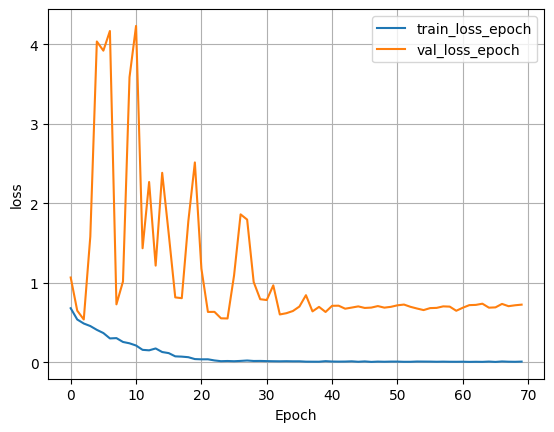

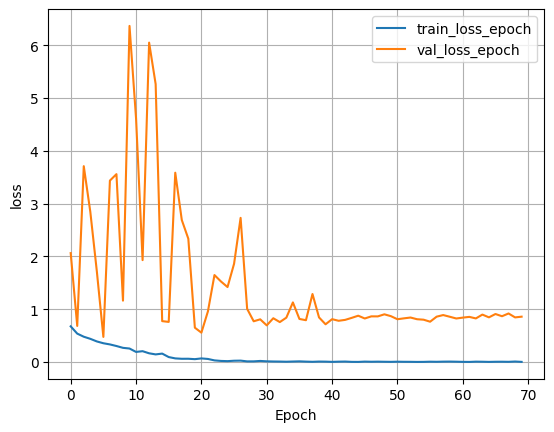

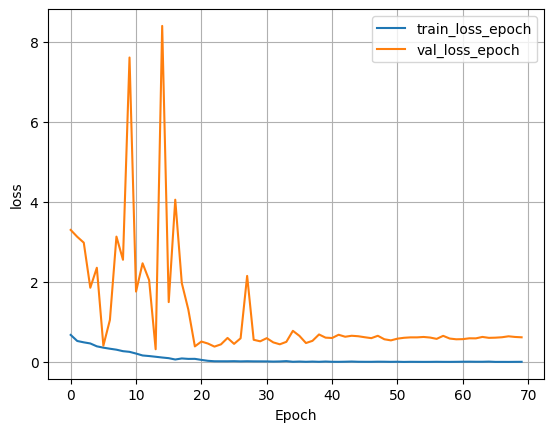

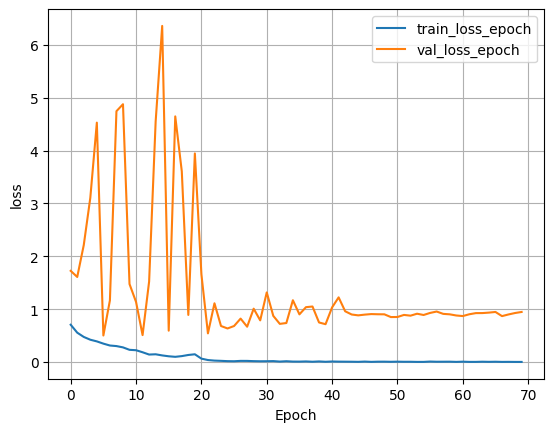

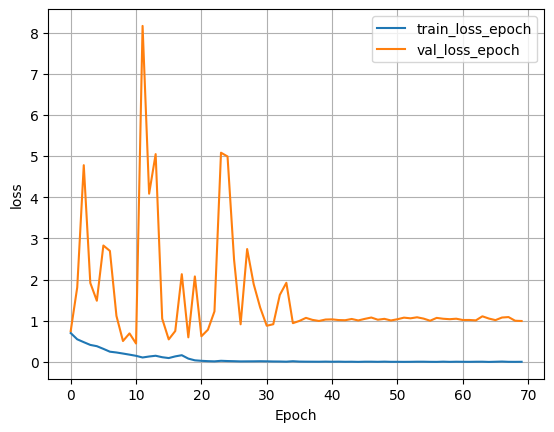

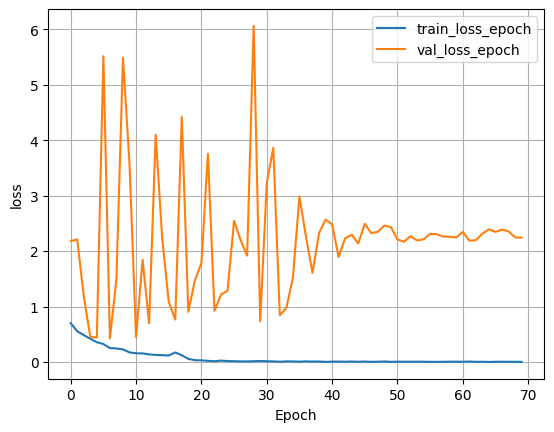

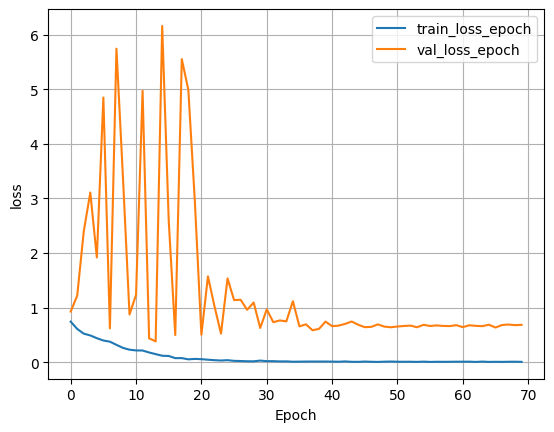

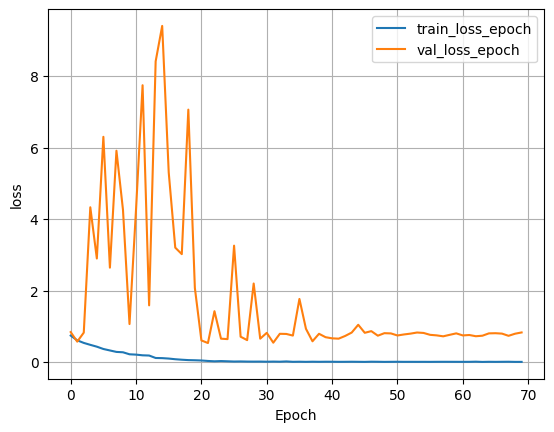

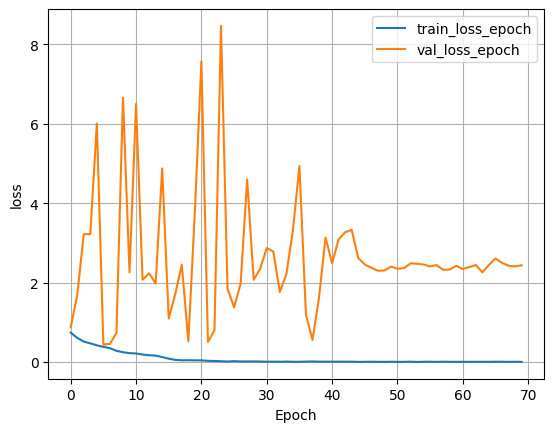

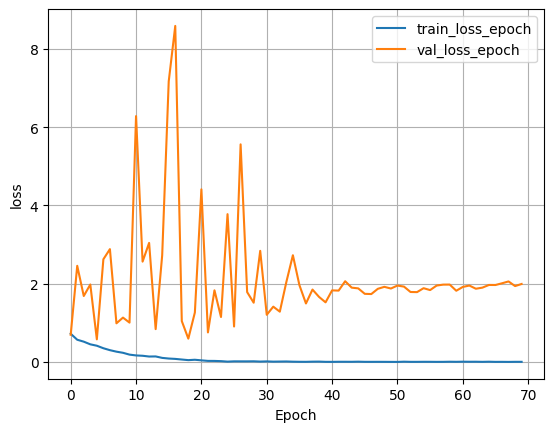

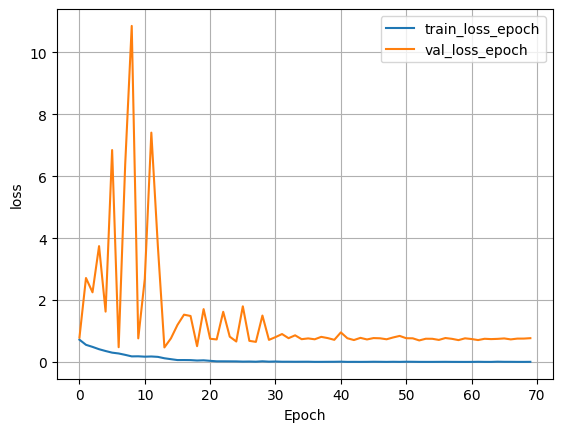

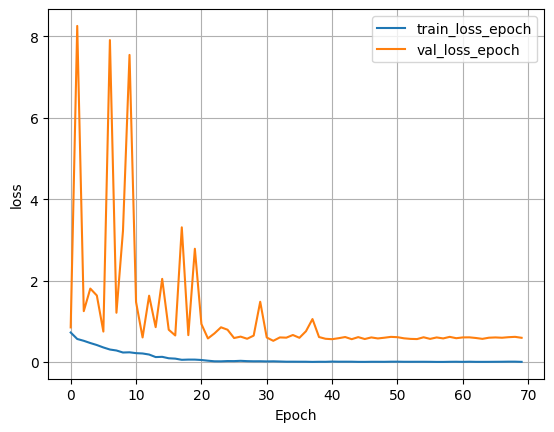

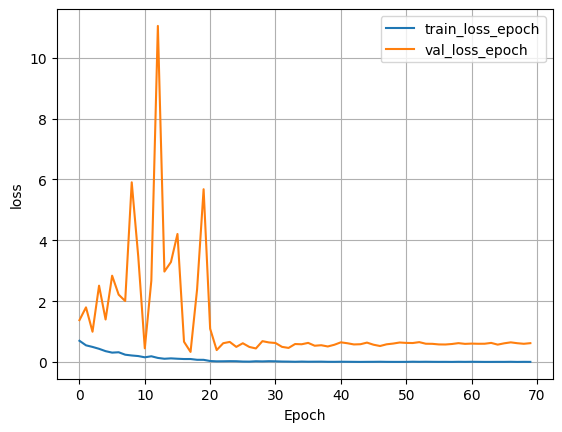

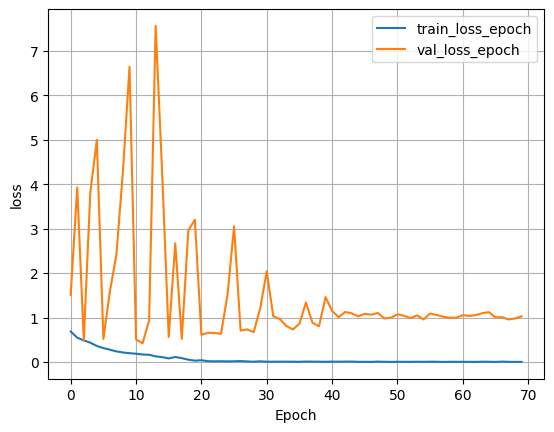

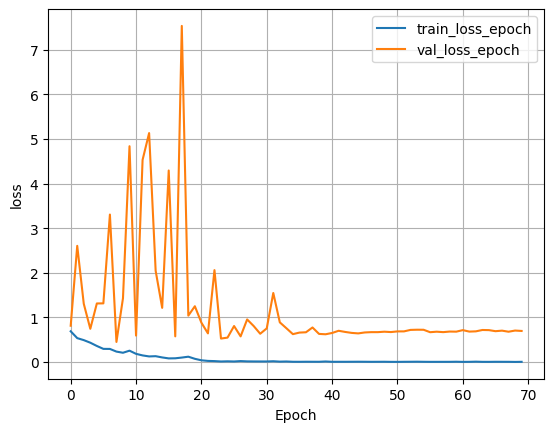

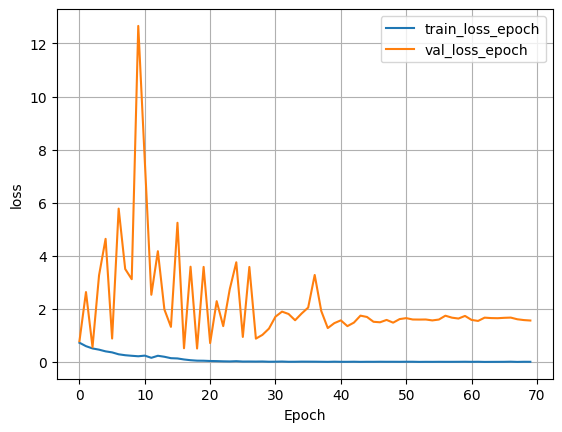

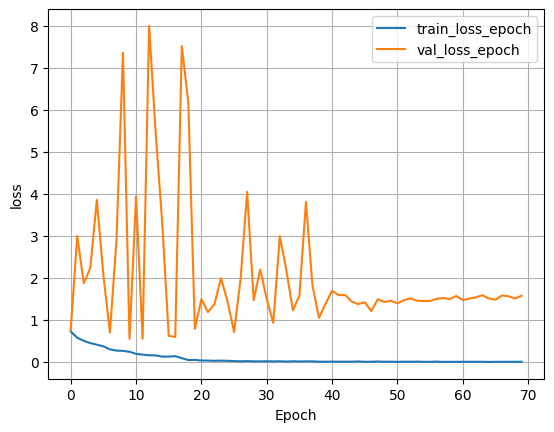

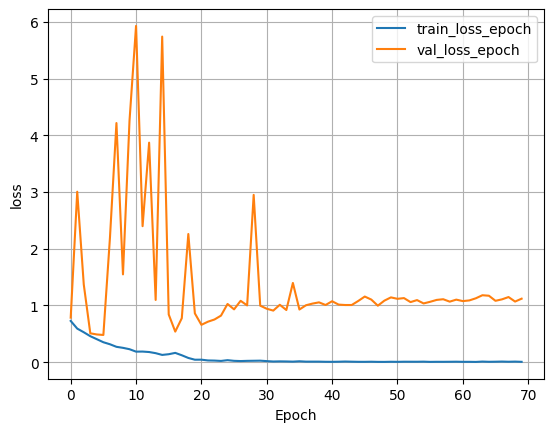

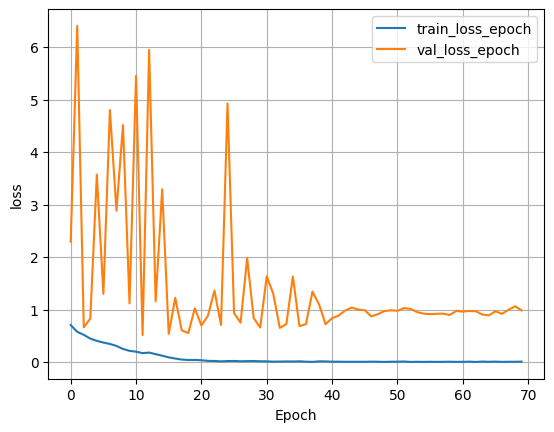

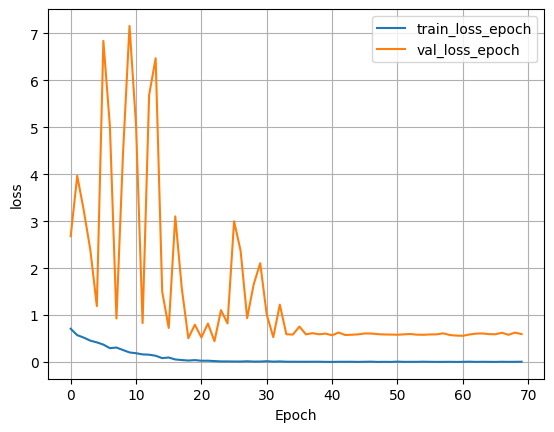

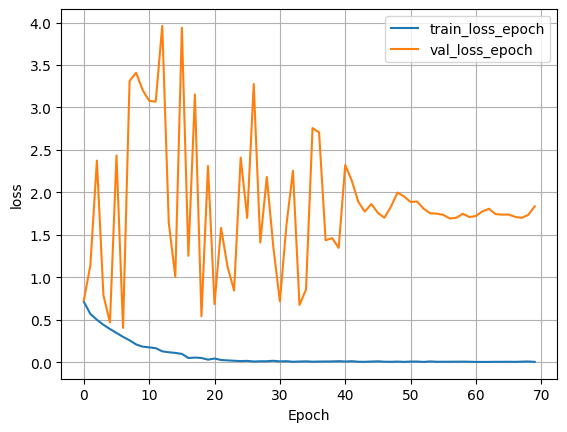

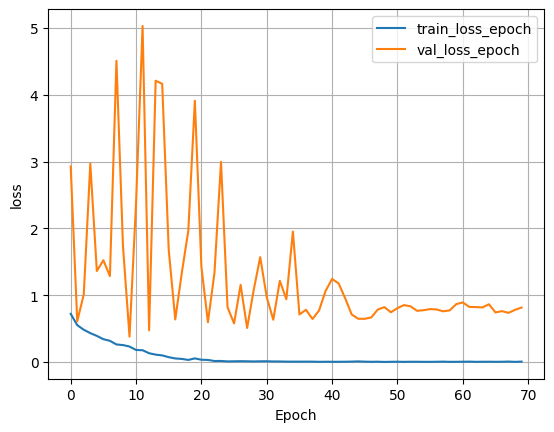

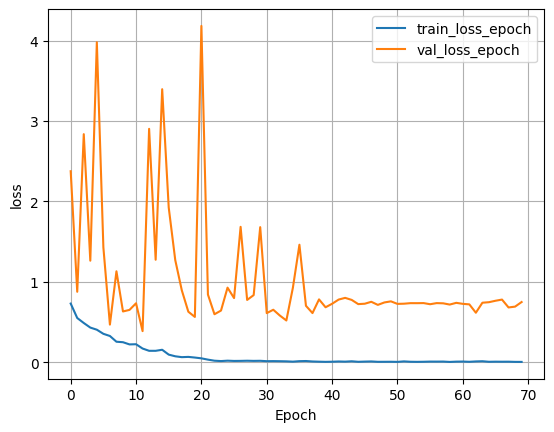

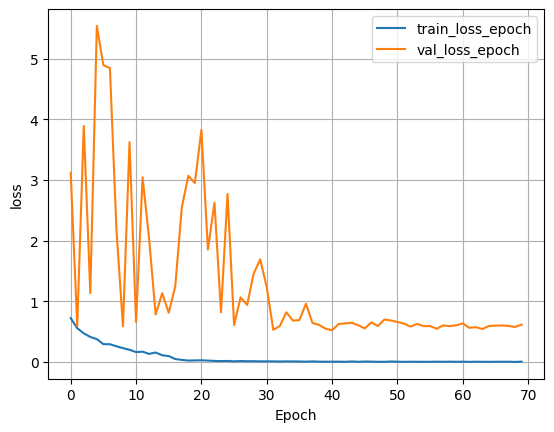

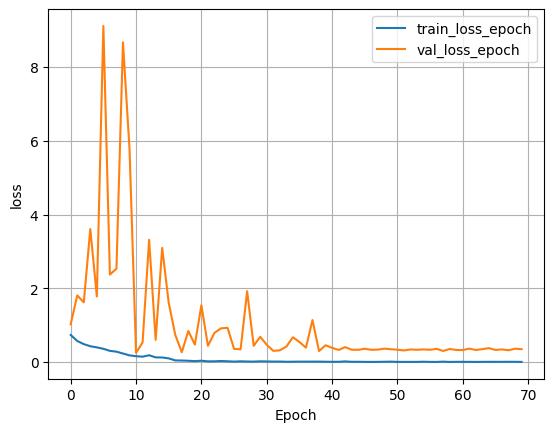

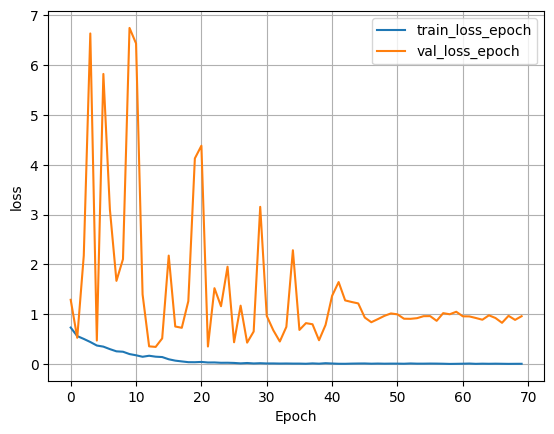

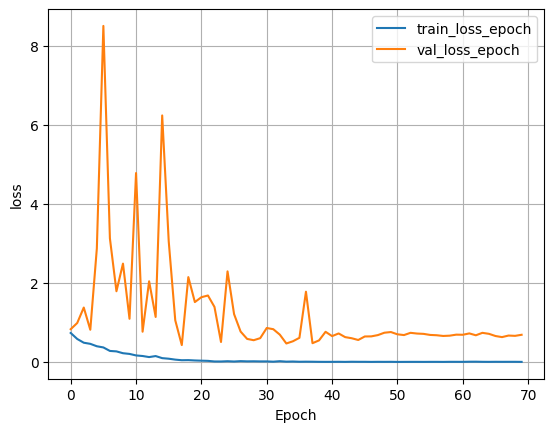

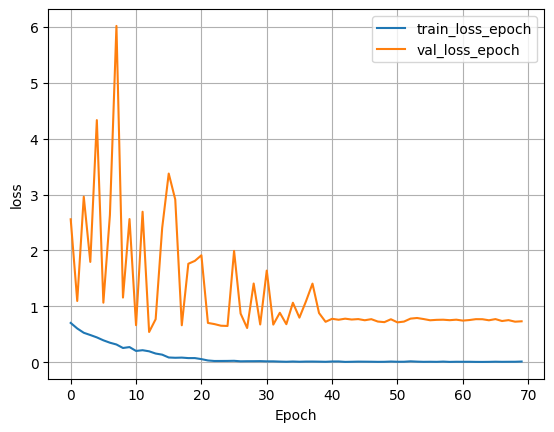

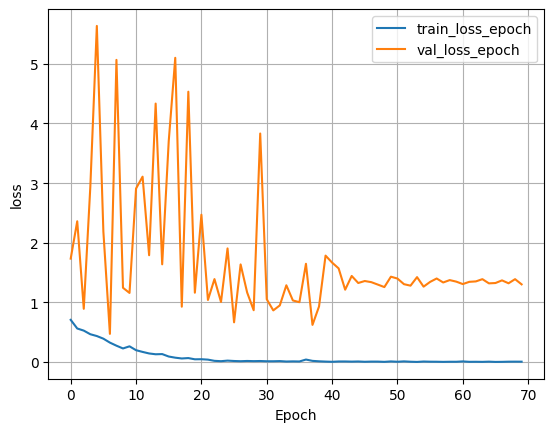

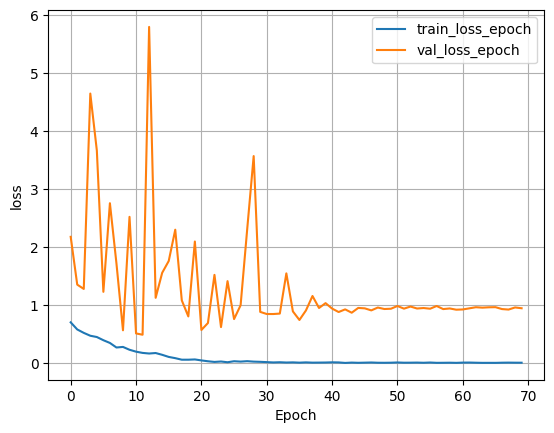

In [ ]:
for i in range(10):
    train_dataset.set_active_fold(i)
    test_dataset.set_active_fold(i)
    # max_token_count = max(train_dataset.max_token_count, test_dataset.max_token_count)
    train_dataloader = CharacterandTokenLevelDataLoader(train_dataset, batch_size=batch_size, drop_last=False, shuffle=False)
    test_dataloader = CharacterandTokenLevelDataLoader(test_dataset, batch_size=batch_size, drop_last=False, shuffle=False)
    for j in range(3):
        model_manager = train_model(70, 0.2, 0.000011, 0.0032)
        time.sleep(60)
        torch.cuda.empty_cache()
        import gc
        gc.collect()
        time.sleep(60)

In [116]:
X, y = next(iter(test_dataloader))

In [52]:
def get_best_results(execution_number=0, base_path='logs/CNN-GNN15_imdb_sentiments/'):
    base_path = path.join(base_path, rf'version_{execution_number}')
    best_ckpts = [f for f in os.listdir(path.join(base_path, 'checkpoints'))][:2]
    best_epochs = [int(re.search(r'\d+', ckpt).group()) for ckpt in best_ckpts ]
    
    metrics = pd.read_csv(path.join(base_path, 'metrics.csv'))

    aggregation_metrics = []
    agg_col = 'epoch'
    for i, dfg in metrics.groupby(agg_col):
        agg = dict(dfg.mean())
        agg[agg_col] = i
        aggregation_metrics.append(agg)
    df_metrics = pd.DataFrame(aggregation_metrics)
    
    print(f"{df_metrics['val_acc_epoch'][best_epochs]}")
    print(f"{df_metrics['val_loss_epoch'][best_epochs]}")

In [53]:
get_best_results(2, 'logs/CNN-GNN_mr2k')

33    0.87
55    0.87
Name: val_acc_epoch, dtype: float64
33    0.842052
55    0.765401
Name: val_loss_epoch, dtype: float64


In [54]:
def get_float_numbers(line_str):
    line_str = str.split(line_str, sep=":")[-1]
    all_floats = re.findall(r"[-+]?(?:\d*\.*\d+)", line_str)
    all_floats = np.array([float(fs) for fs in all_floats])
    return all_floats

In [55]:
def get_best_results(execution_number=0, base_path='logs/CNN-GNN15_imdb_sentiments/'):
    base_path = os.path.join(base_path, rf'version_{execution_number}')
    
    best_ckpts = [f for f in os.listdir(path.join(base_path, 'checkpoints'))][:2]
    best_epochs = [int(re.search(r'\d+', ckpt).group()) for ckpt in best_ckpts ]
    
    metrics = pd.read_csv(path.join(base_path, 'metrics.csv'))

    aggregation_metrics = []
    agg_col = 'epoch'
    for i, dfg in metrics.groupby(agg_col):
        agg = dict(dfg.mean())
        agg[agg_col] = i
        aggregation_metrics.append(agg)
    df_metrics = pd.DataFrame(aggregation_metrics)
    
    max_acc_idx = df_metrics['val_acc_epoch'][best_epochs].argmax()
    # print(max_acc_idx)
    # print(f"{df_metrics['val_acc_epoch'][best_epochs]}")
    # print(f"{df_metrics['val_loss_epoch'][best_epochs]}")
    
    
    with open(path.join(base_path, 'best_model_test_metrics.txt'), 'rt') as f:
        all_lines = f.readlines()

    accuracy = np.mean(get_float_numbers(all_lines[13]))
    # print(f"accuracy: {accuracy}")
    precision = np.mean(get_float_numbers(all_lines[14]))
    # print(f"precision: {precision}")
    recall = np.mean(get_float_numbers(all_lines[15]))
    # print(f"recall: {recall}")
    f1_score = 2*precision*recall/(precision+recall)
    # print(f"f1_score: {f1_score}")
    loss = df_metrics['val_loss_epoch'][best_epochs[max_acc_idx]]
    # print(f"loss: {loss}")
    return loss, accuracy, precision, recall, f1_score

In [56]:
def calculate_mean(execution_numbers, base_path='logs/CNN-GNN15_imdb_sentiments/'):
    losses, accuracies, precisions, recalls, f1_scores = [], [], [], [], []
    for i in execution_numbers:
        loss, accuracy, precision, recall, f1_score = get_best_results(i, base_path)
        losses.append(loss)
        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1_score)
    losses, accuracies, precisions, recalls, f1_scores = np.mean(losses),  np.mean(accuracies),  np.mean(precisions),  np.mean(recalls),  np.mean(f1_scores)
    return {'losses': losses, 'accuracies':accuracies, 'precisions':precisions, 'recalls':recalls, 'f1_scores':f1_scores}

In [59]:
calculate_mean([1, 2, 3], base_path='logs/CNN-GNN_mr2k')

{'losses': 0.6160329580307007,
 'accuracies': 0.8716666666666667,
 'precisions': 0.8758450400000001,
 'recalls': 0.8717371749999999,
 'f1_scores': 0.8737835651527162}

In [60]:
def calculate_max(execution_numbers, base_path='logs/CNN-GNN15_imdb_sentiments/'):
    losses, accuracies, precisions, recalls, f1_scores = [], [], [], [], []
    for i in execution_numbers:
        loss, accuracy, precision, recall, f1_score = get_best_results(i, base_path)
        losses.append(loss)
        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1_score)
    losses, accuracies, precisions, recalls, f1_scores = np.min(losses),  np.max(accuracies),  np.max(precisions),  np.max(recalls),  np.max(f1_scores)
    return {'losses': losses, 'accuracies':accuracies, 'precisions':precisions, 'recalls':recalls, 'f1_scores':f1_scores}

In [62]:
calculate_mean(np.arange(1, 31), base_path='logs/CNN-GNN_mr2k')

{'losses': 0.5939708222945531,
 'accuracies': 0.8713333333333335,
 'precisions': 0.8743923943333333,
 'recalls': 0.8705404375,
 'f1_scores': 0.8724484809063496}